# Lab 5 - Convolution Neural Network 

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
print(torch.cuda.is_available())

False


/home/student/Documents/220962436_Keshav/dllab/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Q1

In [3]:
image = torch.rand(6,6)
print("image=", image)

image = image.unsqueeze(dim=0)
print("image.shape=", image.shape)
image = image.unsqueeze(dim=0)
print("image.shape=", image.shape)
print("image=", image)
kernel = torch.ones(3,3)

print("kernel=", kernel)
kernel = kernel.unsqueeze(dim=0)
kernel = kernel.unsqueeze(dim=0)

outimage = F.conv2d(image, kernel, stride=1, padding=0)
print("outimage=", outimage)

image= tensor([[0.6989, 0.2519, 0.3185, 0.9894, 0.8294, 0.9608],
        [0.0981, 0.7196, 0.5627, 0.2957, 0.5509, 0.1535],
        [0.6965, 0.5248, 0.6090, 0.9121, 0.1603, 0.2826],
        [0.4413, 0.4804, 0.4415, 0.4577, 0.4936, 0.8077],
        [0.8824, 0.0164, 0.3297, 0.9191, 0.8146, 0.4179],
        [0.6142, 0.0092, 0.7028, 0.7159, 0.0388, 0.0426]])
image.shape= torch.Size([1, 6, 6])
image.shape= torch.Size([1, 1, 6, 6])
image= tensor([[[[0.6989, 0.2519, 0.3185, 0.9894, 0.8294, 0.9608],
          [0.0981, 0.7196, 0.5627, 0.2957, 0.5509, 0.1535],
          [0.6965, 0.5248, 0.6090, 0.9121, 0.1603, 0.2826],
          [0.4413, 0.4804, 0.4415, 0.4577, 0.4936, 0.8077],
          [0.8824, 0.0164, 0.3297, 0.9191, 0.8146, 0.4179],
          [0.6142, 0.0092, 0.7028, 0.7159, 0.0388, 0.0426]]]])
kernel= tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
outimage= tensor([[[[4.4800, 5.1837, 5.2279, 5.1347],
          [4.5738, 5.0034, 4.4834, 4.1141],
          [4.4219, 4.6906, 5

### Q2

In [4]:
image = torch.rand(1, 1, 6, 6)

conv_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0)
output_conv2d = conv_layer(image)
print("Output using torch.nn.Conv2d: ", output_conv2d.shape)

kernel = torch.rand(3, 1, 3, 3)  # Shape for 3 output channels, 1 input channel, 3x3 kernel
output_func_conv2d = F.conv2d(image, kernel, stride=1, padding=0)
print("Output using torch.nn.functional.conv2d: ", output_func_conv2d.shape)


Output using torch.nn.Conv2d:  torch.Size([1, 3, 4, 4])
Output using torch.nn.functional.conv2d:  torch.Size([1, 3, 4, 4])


### Q3

Epoch 1, Loss: 0.2673646696100532
Epoch 2, Loss: 0.08096915339606243
Epoch 3, Loss: 0.05714630679428967
Epoch 4, Loss: 0.045608747489455
Epoch 5, Loss: 0.03721682298443228


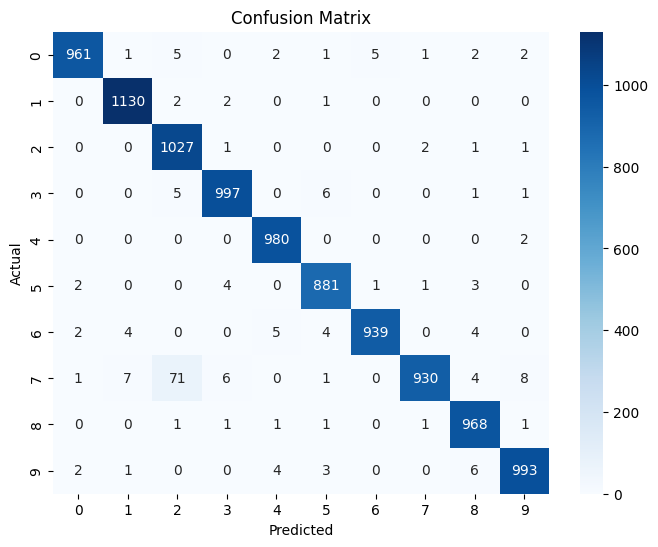

Total learnable parameters: 149798


In [5]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2),
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2)
        )
        self.classification_head = nn.Sequential(
            nn.Linear(64, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        features = self.net(x)
        return self.classification_head(features.view(batch_size, -1))

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, trainloader, epochs=5):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

train_model(model, trainloader)

def evaluate_model(model, testloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, testloader)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {num_params}")

### Q4

In [6]:
class SmallerCNNModel(nn.Module):
    def __init__(self):
        super(SmallerCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Reduced number of filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Reduced number of units in fully connected layer
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 7 * 7)  # Flatten the output from the convolution layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

smaller_model = SmallerCNNModel()

num_params_smaller = sum(p.numel() for p in smaller_model.parameters() if p.requires_grad)
print(f"Total number of learnable parameters in the smaller model: {num_params_smaller}")


Total number of learnable parameters in the smaller model: 105866
